# Model Development

For this exercise, we would like to see how you would approach implementing a service to provide predicting of sales. We would like to see you create a backend service to serve a model in a 'production' environment.


To create the model service please create a toy model using the data we included. We included data from grocery stores ordering on our platform (please see pod_foods_data_example.csv for the data dictionary). The data are from consecutive months, Jan 1st through May 30th. We would like you to make predictions in terms of the quantity of a given product in the next 30 days (i.e. 40 cases in Jun 1 - Jun 30). You can take the data via this link to do the exercise.


Please do not spend an inordinate amount of time optimizing variables or accuracy. The primary purpose of this exercise is to understand how you would approach designing a back-end service to serve up prediction. Given the limitations of the data and the general limitation of time, our evaluation will be focused on the service itself and not toy model. Where you feel you can add more value, please write comments and we can discuss these points during the next stages of the interview.


You can send your completed work in the following way:



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
from itertools import product
from sklearn import preprocessing
from xgboost import plot_tree
from matplotlib import pyplot

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
order_df = pd.read_csv("../../database/data_order.csv", parse_dates=["CHECKOUT_DATE"])

In [4]:
order_df.head(5)

,ORDER_ID,STORE_ID,REGION_ID,BRAND_ID,PRODUCT_ID,PRODUCT_VARIANT_ID,QUANTITY,VARIANT_CASE_PRICE_CENTS,CHECKOUT_DATE
0,23501,274,2,1779,4048,12344,1,5200,2022-01-25
1,23463,629,3,1953,4661,14243,1,2004,2022-01-24
2,23501,274,2,1543,3956,12149,1,2010,2022-01-25
3,23502,275,2,1119,2552,8275,4,3600,2022-01-25
4,23502,275,2,1119,3668,11553,2,2900,2022-01-25


In [5]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75318 entries, 0 to 75317
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ORDER_ID                  75318 non-null  int64         
 1   STORE_ID                  75318 non-null  int64         
 2   REGION_ID                 75318 non-null  int64         
 3   BRAND_ID                  75318 non-null  int64         
 4   PRODUCT_ID                75318 non-null  int64         
 5   PRODUCT_VARIANT_ID        75318 non-null  int64         
 6   QUANTITY                  75318 non-null  int64         
 7   VARIANT_CASE_PRICE_CENTS  75318 non-null  int64         
 8   CHECKOUT_DATE             75318 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(8)
memory usage: 5.2 MB


In [6]:
order_df.shape

(75318, 9)

## EDA


#### Exploring time series patterns

In [7]:
order_df['checkout_month'] = order_df['CHECKOUT_DATE'].dt.month
order_df['checkout_dow'] = order_df['CHECKOUT_DATE'].dt.dayofweek
order_df['checkout_woy'] = order_df['CHECKOUT_DATE'].dt.isocalendar().week

order_df['checkout_woy'] = np.where(order_df['checkout_woy']==52, 1, order_df['checkout_woy'])
# order_df['day^year'] = np.log((np.log(order_df['CHECKOUT_DOY'] + 1)) ** (order_df['CHECKOUT_YEAR'] - 2000))

<AxesSubplot: xlabel='CHECKOUT_DATE'>

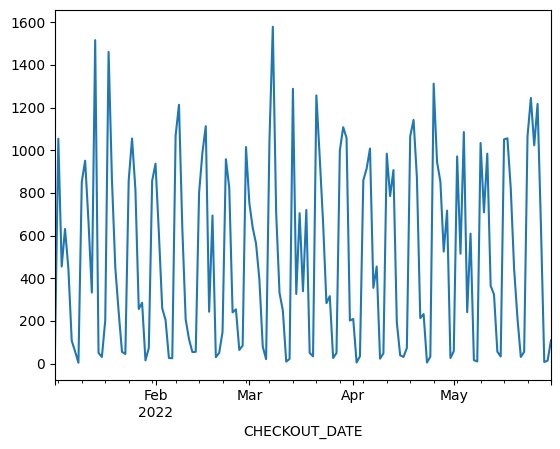

In [8]:
order_df.groupby(['CHECKOUT_DATE'])['ORDER_ID'].count().plot(kind='line')

<AxesSubplot: xlabel='checkout_dow'>

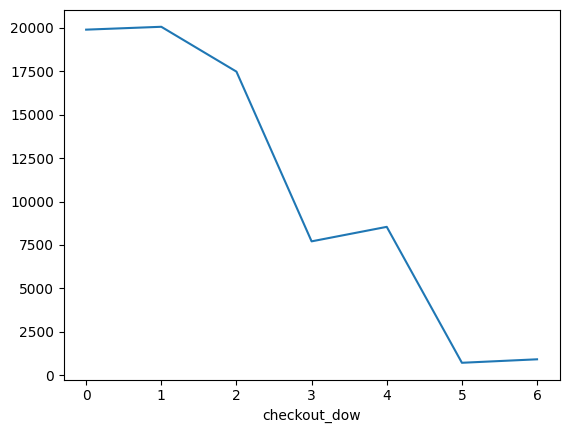

In [9]:
order_df.groupby(['checkout_dow'])['ORDER_ID'].count().plot(kind='line')

<AxesSubplot: xlabel='checkout_woy'>

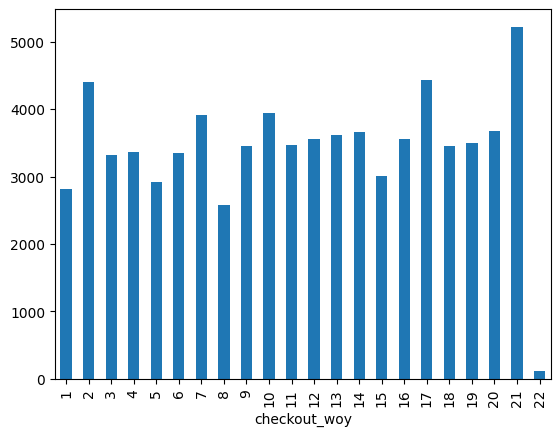

In [10]:
order_df.groupby(['checkout_woy'])['ORDER_ID'].count().plot(kind='bar')

<AxesSubplot: xlabel='checkout_month'>

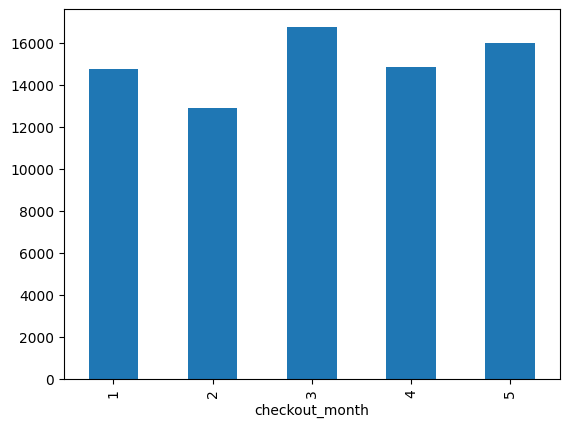

In [11]:
order_df.groupby(['checkout_month'])['ORDER_ID'].count().plot(kind='bar')

## Preprocessing

### Order

In [12]:
def get_store_product_data(order_df):
	store_product_df = order_df.groupby(['STORE_ID','PRODUCT_ID','CHECKOUT_DATE'],as_index=False)['QUANTITY'].sum()
	return store_product_df

store_product_df = get_store_product_data(order_df)

### Product

In [13]:
product_df = pd.read_csv('../../database/data_metadata_product.csv')

In [14]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8890 entries, 0 to 8889
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PRODUCT_ID        8890 non-null   int64 
 1   PRODUCT_METADATA  8890 non-null   object
dtypes: int64(1), object(1)
memory usage: 139.0+ KB


In [15]:
product_df.head()

,PRODUCT_ID,PRODUCT_METADATA
0,6280,Snack Bars
1,6499,Sweeteners + Syrup
2,5532,Desserts
3,2608,Hemp Ingestibles
4,2252,Hemp


In [16]:
product_df.groupby('PRODUCT_METADATA', as_index=False).size().sort_values(by='PRODUCT_METADATA')

,PRODUCT_METADATA,size
0,Appetizers + Snacks,19
1,Baby & Child,11
2,Bacon,5
3,Baked Goods,44
4,Bakery,193
...,...,...
83,Tea,118
84,Tortillas + Wraps,4
85,Waters,48
86,Wellness,805


In [17]:
product_df.groupby('PRODUCT_ID', as_index=False).size().query('size>1')

,PRODUCT_ID,size
0,127,2
1,133,2
2,134,2
3,136,2
4,137,2
...,...,...
4474,6718,2
4475,6719,2
4476,6720,2
4477,6721,2


In [18]:
product_df.merge(
	product_df.groupby('PRODUCT_ID', as_index=False).size().query('size==1'),
	how='inner',
	on='PRODUCT_ID'
)['PRODUCT_METADATA'].unique()

array(['Confections'], dtype=object)

In [19]:
product_df['DUP_CNT'] = product_df.groupby('PRODUCT_ID')['PRODUCT_METADATA'].rank(method="first", ascending=True)

In [20]:
cate_df = pd.merge(
	product_df[product_df['DUP_CNT']==1],
	product_df[product_df['DUP_CNT']==2],
	how='outer',
	on='PRODUCT_ID'
)[['PRODUCT_METADATA_x', 'PRODUCT_METADATA_y']].drop_duplicates().reset_index(drop=True)

In [21]:
def cross_count(count_value_in:pd.Series, count_range:pd.Series):
	result = []
	for x in list(count_value_in):
		result.append(list(count_range).count(x))

	return result

In [22]:
cate_df['cross_count_x'] = cross_count(cate_df['PRODUCT_METADATA_x'], cate_df['PRODUCT_METADATA_y'])
cate_df['cross_count_y'] = cross_count(cate_df['PRODUCT_METADATA_y'], cate_df['PRODUCT_METADATA_x'])

cate_df['self_count_x'] = cate_df.groupby('PRODUCT_METADATA_x')['PRODUCT_METADATA_x'].transform('count')
cate_df['self_count_y'] = cate_df.groupby('PRODUCT_METADATA_y')['PRODUCT_METADATA_y'].transform('count')

cate_df['all_count_x'] = cate_df['cross_count_x'] + cate_df['self_count_x']
cate_df['all_count_y'] = cate_df['cross_count_y'] + cate_df['self_count_y']

In [23]:
cate_df['SUB_CATE'] = np.where(cate_df['all_count_x'] < cate_df['all_count_y'], cate_df['PRODUCT_METADATA_x'], cate_df['PRODUCT_METADATA_y'])

cate_df['SUB_CATE'] = np.where(cate_df['PRODUCT_METADATA_x'].str.contains('+', regex=False), cate_df['PRODUCT_METADATA_x'], cate_df['SUB_CATE'])
cate_df['SUB_CATE'] = np.where(cate_df['PRODUCT_METADATA_y'].str.contains('+', regex=False), cate_df['PRODUCT_METADATA_y'], cate_df['SUB_CATE'])

cate_df['CATE'] = np.where(cate_df['SUB_CATE']==cate_df['PRODUCT_METADATA_x'],cate_df['PRODUCT_METADATA_y'], cate_df['PRODUCT_METADATA_x'])

cate_df['SUB_CATE'] = np.where(cate_df['SUB_CATE'].isnull(), 'Other ' + cate_df['CATE'], cate_df['SUB_CATE'])

In [24]:
product_df = product_df.merge(
	cate_df[['SUB_CATE','CATE']], 
	how='left',
	left_on='PRODUCT_METADATA',
	right_on='SUB_CATE')

In [25]:
product_df.dropna(inplace=True)
product_df.drop(columns=['PRODUCT_METADATA','DUP_CNT'], inplace=True)

### Store

In [26]:
store_df = pd.read_csv('../../database/data_metadata_store.csv')

In [27]:
store_df.head()

,STORE_ID,STORE_TYPE,REGION_ID,STORE_SIZE
0,982,Independent,3.0,1.0
1,1225,Natural chain,12.0,5.0
2,1969,Natural chain,11.0,4.0
3,2331,Online,4.0,5.0
4,2235,Independent,NaN,4.0


In [28]:
store_df.groupby('STORE_ID', as_index=False).size().query('size>1')

,STORE_ID,size


In [29]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555 entries, 0 to 2554
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STORE_ID    2555 non-null   int64  
 1   STORE_TYPE  2383 non-null   object 
 2   REGION_ID   2469 non-null   float64
 3   STORE_SIZE  2140 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 80.0+ KB


In [30]:
store_df['STORE_TYPE'].fillna('Unknown', inplace=True)
store_df['REGION_ID'].fillna(-1, inplace=True)
store_df['STORE_SIZE'] .fillna(0, inplace=True)
# store_df['STORE_SIZE'] = store_df.groupby(['STORE_TYPE', 'REGION_ID'])['STORE_SIZE'].transform(lambda x: x.fillna(x.mean()))

In [31]:
store_df.rename(columns={'REGION_ID':'STORE_REGION_ID'}, inplace=True)

### Joining all data

In [32]:
def join_all_data(store_product_df, store_df, product_df):
	
	final_df = store_product_df.merge(store_df, how='left', on='STORE_ID') \
						.merge(product_df, how='left', on='PRODUCT_ID').sort_values(by='CHECKOUT_DATE', ascending=True)

	final_df.sort_values(by=['CHECKOUT_DATE','STORE_ID','PRODUCT_ID'], ascending=True, inplace=True)

	return final_df

In [33]:
lb = preprocessing.LabelEncoder()

In [34]:
final_df = join_all_data(store_product_df, store_df, product_df)

In [35]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42633 entries, 403 to 24955
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   STORE_ID         42633 non-null  int64         
 1   PRODUCT_ID       42633 non-null  int64         
 2   CHECKOUT_DATE    42633 non-null  datetime64[ns]
 3   QUANTITY         42633 non-null  int64         
 4   STORE_TYPE       42633 non-null  object        
 5   STORE_REGION_ID  42633 non-null  float64       
 6   STORE_SIZE       42633 non-null  float64       
 7   SUB_CATE         42208 non-null  object        
 8   CATE             42208 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 3.3+ MB


In [36]:
final_df['STORE_TYPE'] = lb.fit_transform(final_df['STORE_TYPE'])
final_df['CATE'] = lb.fit_transform(final_df['CATE'])
final_df['SUB_CATE'] = lb.fit_transform(final_df['SUB_CATE'])

## Feature Engineering

### Time

In [37]:
final_df['checkout_dow'] = final_df['CHECKOUT_DATE'].dt.dayofweek
final_df['checkout_day'] = final_df['CHECKOUT_DATE'].dt.day

### Quantity

#### Rolling Mean

In [38]:
feature_list_1 = {
	'avg_qty_store_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'STORE_ID', 'window':30},
	# 'avg_qty_region_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'REGION_ID', 'window':30},
	# 'avg_qty_brand_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'BRAND_ID', 'window':30},
	'avg_qty_product_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'PRODUCT_ID', 'window':30},
	'avg_qty_storetype_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'STORE_TYPE', 'window':30},
	'avg_qty_storeregion_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'STORE_REGION_ID', 'window':30},
	'avg_qty_cate_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'CATE', 'window':30},
	'avg_qty_subcate_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':'SUB_CATE', 'window':30},
	'avg_qty_store_product_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':['STORE_ID', 'PRODUCT_ID'], 'window':30},
	'avg_qty_store_cate_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':['STORE_ID', 'CATE'], 'window':30},
	# 'avg_qty_region_cate_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':['REGION_ID', 'CATE'], 'window':30},
	'avg_qty_storeregion_cate_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':['STORE_REGION_ID', 'CATE'], 'window':30},
	# 'avg_qty_region_brand_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':['REGION_ID', 'BRAND_ID'], 'window':30},
	# 'avg_qty_storeregion_brand_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':['STORE_REGION_ID', 'BRAND_ID'], 'window':30},
	# 'avg_qty_region_product_l30d': {'agg':'mean', 'object':'QUANTITY', 'scope':['REGION_ID', 'PRODUCT_ID'], 'window':30},
	# 'avg_qty_order_product_l30d': {'agg':'sum', 'object':'QUANTITY', 'scope':['ORDER_ID','PRODUCT_ID'], 'window':30},
	# 'avg_qty_order_product_l7d': {'agg':'sum', 'object':'QUANTITY', 'scope':['ORDER_ID','PRODUCT_ID'], 'window':7},
}

In [39]:
for key, val in feature_list_1.items():
	final_df[key] = final_df.groupby(val['scope'])[val['object']].transform(lambda x: x.rolling(window=val['window']).agg(val['agg']))
	final_df[key].fillna(0, inplace=True)

#### Lags

In [40]:
lags = [1,2,3,4,5,6,7,14,28]
for lag in lags:
    final_df[f'qty_store_product_lag_{lag}'] = final_df.groupby(['STORE_ID','PRODUCT_ID'],as_index=False)['QUANTITY'].shift(lag)

### Product Variety

In [41]:
feature_list_2 = {
	'dcnt_product_store_daily': {'agg':'nunique', 'object':'PRODUCT_ID', 'scope':['STORE_ID','CHECKOUT_DATE']},
	'dcnt_cate_store_daily': {'agg':'nunique', 'object':'CATE', 'scope':['STORE_ID','CHECKOUT_DATE']},
	'dcnt_subcate_store_daily': {'agg':'nunique', 'object':'SUB_CATE', 'scope':['STORE_ID','CHECKOUT_DATE']},
	'sum_qty_store_daily': {'agg':'sum', 'object':'QUANTITY', 'scope':['STORE_ID','CHECKOUT_DATE']},
}

In [42]:
for key, val in feature_list_2.items():
	final_df[key] = final_df.groupby(val['scope'])[val['object']].transform(val['agg'])

In [43]:
lags = [1,3,7]
for lag in lags:
    for k in feature_list_2.keys():
        final_df[f'{k}_lag_{lag}'] = final_df.groupby(['STORE_ID','PRODUCT_ID'],as_index=False)[k].shift(lag)

In [44]:
train_val = final_df[final_df['CHECKOUT_DATE'].dt.month!=5]
test = final_df[final_df['CHECKOUT_DATE'].dt.month==5]

print('train size / test size : ', f'{(train_val.shape[0] / final_df.shape[0]):.{2}}',  '/', f'{(test.shape[0] / final_df.shape[0]):.{2}}', ' or ', f"{train_val.shape[0]} / {test.shape[0]}")

train size / test size :  0.79 / 0.21  or  33621 / 9012


In [45]:
split_at = int(len(train_val) * (1 - 0.15))
train = train_val.iloc[:split_at]
val = train_val.iloc[split_at:]
print('train size / val size : ', f'{(train.shape[0] / train_val.shape[0]):.{2}}',  '/', f'{(val.shape[0] / train_val.shape[0]):.{2}}', ' or ', f"{train.shape[0]} / {val.shape[0]}")

train size / val size :  0.85 / 0.15  or  28577 / 5044


In [46]:
import lightgbm as lgb

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28577 entries, 403 to 12535
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   STORE_ID                        28577 non-null  int64         
 1   PRODUCT_ID                      28577 non-null  int64         
 2   CHECKOUT_DATE                   28577 non-null  datetime64[ns]
 3   QUANTITY                        28577 non-null  int64         
 4   STORE_TYPE                      28577 non-null  int64         
 5   STORE_REGION_ID                 28577 non-null  float64       
 6   STORE_SIZE                      28577 non-null  float64       
 7   SUB_CATE                        28577 non-null  int64         
 8   CATE                            28577 non-null  int64         
 9   checkout_dow                    28577 non-null  int64         
 10  checkout_day                    28577 non-null  int64         
 11  

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [84]:
import xgboost as xgb

In [83]:
model = xgboost.XGBRegressor()

In [87]:
X_train = train.drop(['QUANTITY','CHECKOUT_DATE'], axis=1)
y_train = train['QUANTITY']
X_test = test.drop(['QUANTITY','CHECKOUT_DATE'], axis=1)
y_test = test['QUANTITY']

In [88]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[0]	validation_0-rmse:9.32295	validation_1-rmse:8.98730
[1]	validation_0-rmse:7.94254	validation_1-rmse:7.95360
[2]	validation_0-rmse:6.83028	validation_1-rmse:7.19531
[3]	validation_0-rmse:5.92778	validation_1-rmse:6.63218
[4]	validation_0-rmse:5.19514	validation_1-rmse:6.20388
[5]	validation_0-rmse:4.60816	validation_1-rmse:5.92963


/home/truonghm/miniconda3/envs/pf/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:4.10621	validation_1-rmse:5.77184
[7]	validation_0-rmse:3.67422	validation_1-rmse:5.53255
[8]	validation_0-rmse:3.32691	validation_1-rmse:5.37828
[9]	validation_0-rmse:3.05465	validation_1-rmse:5.29001
[10]	validation_0-rmse:2.85751	validation_1-rmse:5.22658
[11]	validation_0-rmse:2.67595	validation_1-rmse:5.14449
[12]	validation_0-rmse:2.53892	validation_1-rmse:5.08293
[13]	validation_0-rmse:2.42246	validation_1-rmse:5.05213
[14]	validation_0-rmse:2.33737	validation_1-rmse:5.02524
[15]	validation_0-rmse:2.28269	validation_1-rmse:5.00759
[16]	validation_0-rmse:2.21226	validation_1-rmse:4.95007
[17]	validation_0-rmse:2.15029	validation_1-rmse:4.92728
[18]	validation_0-rmse:2.11069	validation_1-rmse:4.92889
[19]	validation_0-rmse:2.07403	validation_1-rmse:4.92447
[20]	validation_0-rmse:2.04757	validation_1-rmse:4.91777
[21]	validation_0-rmse:2.02590	validation_1-rmse:4.91896
[22]	validation_0-rmse:2.01255	validation_1-rmse:4.92052
[23]	validation_0-rmse:1.99468	vali

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

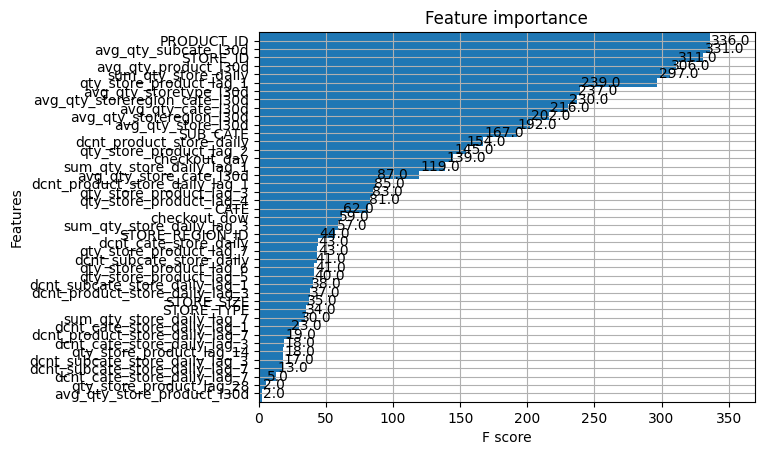

In [91]:
_ = xgb.plot_importance(reg, height=3)

In [97]:
y_pred = reg.predict(X_test)

In [99]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 23.69
RMSE: 4.87


<AxesSubplot: xlabel='CHECKOUT_DATE', ylabel='value'>

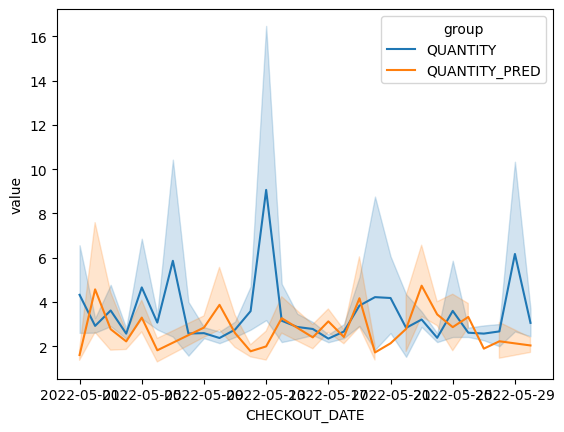

In [101]:
pred_data = pd.concat([test, pd.Series(y_pred, name='QUANTITY_PRED')], axis=1)
plot_data = pd.melt(pred_data, id_vars=['CHECKOUT_DATE'], value_vars=['QUANTITY','QUANTITY_PRED'], var_name='group')
sns.lineplot(data=plot_data, x='CHECKOUT_DATE', y='value', hue='group')

In [103]:
import joblib

In [104]:

with open('pf_model.joblib', 'wb') as model_file:     
    joblib.dump(reg, model_file)